In [2]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func
from diff_func_fitters import fit_polynomial, fit_rational_func, SumFunc, FiniteDiffFunc1D
from gauss_freud_quad import get_nodes_and_weights
from scipy.optimize import brentq
from baryrat import aaa

import mgo

### Dispersion Relation

In [2]:
plot_names = ['const_T']

In [3]:
# Define Warm Plasma Dispersion Relation
import torch
from scipy.constants import e, m_e, epsilon_0, c

# ICs
f0 = 34.8e9
omega0 = 2*np.pi*f0
x0 = 0

# Constants
n0 = 2.07e19
T0 = 38.5*e
L_ne = 2.8434e-2
L_Te = 0.7295*L_ne
B0 = 0.511

sc_x = 1
sc_k = 1
sc_omega = 1

@torch_func
def B(x: ('scalar')):
    return B0 * torch.ones_like(x)

@torch_func
def omega_c(x: ('scalar')):
    return e*B(x)/m_e

@torch_func
def T_e(x: ('scalar'), const: ('any')):
    if const:
        return T0
    else:
        return T0*(1 - x/L_Te)

@torch_func
def n_e(x: ('scalar')):
    return n0*(1 - x/L_ne)

@torch_func
def omega_p_squared(x: ('scalar')):
    return n_e(x) * e**2 / (epsilon_0 * m_e)

@torch_func
def v_Te_squared(x: ('scalar'), const_T: ('any')):
    return 2*T_e(x, const_T)/m_e

@torch_func
def Stix_S(x: ('scalar'), omega: ('scalar')):
    return 1 - (omega_p_squared(x)/(omega**2 - (omega_c(x)**2 )))

@torch_func
def Stix_D(x: ('scalar'), omega: ('scalar')):
    return (omega_c(x)/omega) * (omega_p_squared(x)/(omega**2 - (omega_c(x)**2)))

@torch_func
def lamb(x: ('scalar'), k: ('scalar'), const_T: ('any')):
    return v_Te_squared(x, const_T)/(2 * (omega_c(x)**2)) * (torch.abs(k)**2)

@torch_func
def Omega(x: ('scalar'), omega: ('scalar')):
    return omega/omega_c(x)

@torch_func
def K1_int(x: ('scalar'), k: ('scalar'), omega: ('scalar'), const_T: ('any')):
    _psi = torch.linspace(0, torch.pi, 100)
    return (torch.exp(-lamb(x, k, const_T))
            * torch.trapezoid(
            (torch.sin(torch.outer(_psi, Omega(x, omega).reshape(-1)))
                * torch.outer(torch.sin(_psi), torch.ones_like(x.reshape(-1)))
                * torch.exp(
                    - torch.outer(torch.cos(_psi), lamb(x, k, const_T).reshape(-1))
                    )
            ), _psi, dim=0)
            )

@torch_func
def K1(x: ('scalar'), k: ('scalar'), omega: ('scalar'), const_T: ('any')):
    return ((torch.sin(torch.pi * Omega(x, omega)))
     + (omega_p_squared(x)/(omega_c(x)**2))
        * (K1_int(x, k, omega, const_T))
    )

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar'), const_T: ('any')):
    _x = sc_x * x
    _k = sc_k * k
    _omega = sc_omega * omega
    return (c/_omega)**2 * (K1(_x, _k, _omega, const_T) * (torch.abs(_k)**2) - (torch.sin(torch.pi * Omega(x, omega)))*(_omega/c)**2 * (Stix_S(_x, _omega)**2 - Stix_D(_x, _omega)**2))

def D_vec(x, k, omega, const_T):
    return D(x.flatten(), k.flatten(), omega.flatten(), const_T).reshape(x.shape)

def get_k0(x0, omega0, kmin, kmax, const_T):
    return brentq(lambda k: D(x0, k, omega0, const_T), kmin, kmax)

#### Test Dispersion on a $(x, k, \omega)$ point

In [4]:
k0 = 10e3 / sc_k
f0 = 34.8e9 / sc_omega
omega0 = 2*np.pi*f0
x0 = 1 / sc_x
const_T = True

print(
    'B', B(x0),
    '\n omega_c', omega_c(x0),
    '\n n_e', n_e(x0),
    '\n omega_p_squared', omega_p_squared(x0),
    '\n Stix_S', Stix_S(x0, omega0),
    '\n Stix_D', Stix_D(x0, omega0),
    '\n lambd', lamb(x0, k0, const_T=True),
    '\n v_Te_squared', v_Te_squared(x0, const_T),
    '\n K1_int', K1_int(x0, k0, omega0, const_T),
    '\n K1', K1(x0, k0, omega0, const_T),
    '\n D', D(x0, k0, omega0, const_T),
)

B tensor(0.5110) 
 omega_c tensor(8.9876e+10) 
 n_e tensor(-7.0730e+20) 
 omega_p_squared tensor(-2.2510e+24) 
 Stix_S tensor(57.6540) 
 Stix_D tensor(-23.2870) 
 lambd tensor(0.0838) 
 v_Te_squared 13542914082945.656 
 K1_int tensor([-0.2216]) 
 K1 tensor([62.7274]) 
 D tensor([9071.7676])


In [5]:
omega_c(x0)**2, omega_p_squared(x0)

(tensor(8.0776e+21), tensor(-2.2510e+24))

In [6]:
(omega_c(0.02)**2 + omega_p_squared(0.02))**(1/2)

tensor(1.6619e+11)

#### Plot Dispersion in $(k, f)$ space

In [7]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

k0 325.93468135951144  m^-1


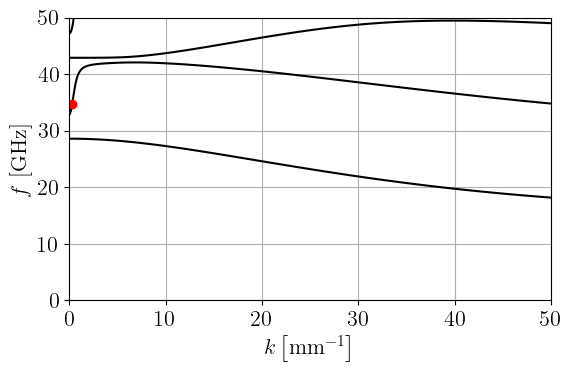

In [8]:
f0 = 34.8e9 / sc_omega
omega0 = 2*np.pi*f0
x0 = 2e-3 / sc_x
ki = np.linspace(0, 50000, 1000) / sc_k
omegai = 2*np.pi*np.linspace(1e-6, 50e9, 1000) / sc_omega
K, O = np.meshgrid(ki, omegai, indexing='ij')

k0 = get_k0(x0, omega0, 0, 500 / sc_k, const_T=True)
print('k0', k0, ' m^-1')

plt.figure(figsize=(6, 4))
plt.contour(K * sc_k * 1e-3, O/(2*np.pi) * sc_omega * 1e-9, D_vec(x0*np.ones_like(K), K, O, const_T=True), levels=[0], colors=['k'])
# plt.plot(plt.gca().get_xlim(), [f0 * sc_omega * 1e-9, f0 * sc_omega * 1e-9], '--', linewidth=1)
plt.plot(k0*1e-3, f0 * 1e-9, 'ro')
plt.ylabel(r'$f$ [GHz]')
plt.xlabel(r'$k \, \mathrm{\left[ mm^{-1} \right]}$')
plt.tight_layout()
plt.grid()
plt.savefig('./plots/XB_dispersion.pdf')
plt.savefig('./plots/XB_dispersion.png', dpi=600)
plt.show()

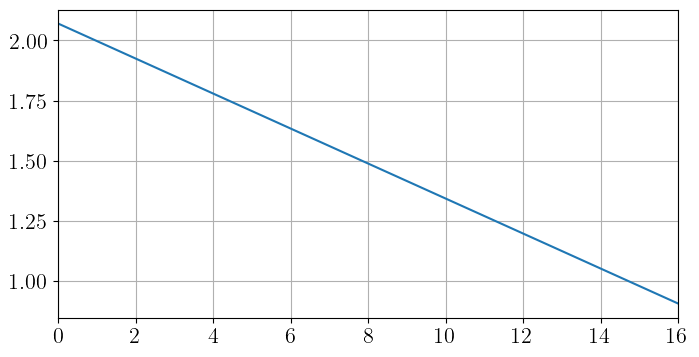

In [9]:
xi = np.linspace(0, 0.016)

plt.figure(figsize=(8,4))
plt.plot(xi*1e3, n_e(xi)*1e-19)
# plt.plot([0, 16], [omega0*1e-9, omega0*1e-9])
# plt.plot(xi, omega_c(xi)*1e-9)
# plt.plot(xi, np.sqrt(omega_p_squared(xi))*1e-9)
plt.xlim(0, 16)
plt.grid()
plt.show()

In [20]:
max_gauss_quad_order = 3

def get_dispersion_manifold(x0, k0, omega0, const_T):
    ND = 1
    nt = 8000
    t, xs, ks, zs, i_start, i_end = trace_ray_1D(x0=x0, k0=k0, omega0=omega0, tmin=0, tmax=40e-9, D=D, D_args={'const_T': const_T}, x_min=x0, tsteps=nt, ghost_ratio=0.01, solve_ivp_args={'method': 'LSODA'}, true_time=True, rtol=1e-9)
    nt = i_end - i_start
    return t, xs, ks, zs, nt, i_start, i_end, x0, k0

def get_mgo_field(phi0, t, zs, analytic_cont, i_start, i_end, i_save=[]):
    branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0, i_start, i_end, i_save=i_save, analytic_cont=analytic_cont, max_gauss_quad_order=max_gauss_quad_order)
    results = mgo_info['saved_results']
    Nt = mgo_info['Nt']
    Upsilon = mgo_info['Upsilon']
    return branch_masks, ray_field, mgo_info, results, Nt, Upsilon

In [21]:
ray_tracing_results = []

for plot_name in plot_names:
    const_T = (plot_name == 'const_T')
    t, xs, ks, zs, nt, i_start, i_end, x0, k0 = get_dispersion_manifold(x0, k0, omega0, const_T=const_T)
    S = mgo.get_symplectic_tangent_trfm(zs, t, 1, i_start, i_end)
    i_caust = np.argmin(np.abs(S[:, 0, 0]))
    if const_T:
        i_dt = int(0.2*nt)
        i_save = np.arange(i_caust - i_dt, i_caust + i_dt, int(2*i_dt/4))
    else:
        i_B0 = np.argmax(np.abs(np.diff(S[:, 0, 1])))
        i_dt = int(0.5 * abs(i_B0-i_caust))
        i_save = [i_caust - i_dt, i_caust, i_caust + i_dt, i_B0, i_B0 + i_dt]
    
    ray_tracing_results.append((t, xs, ks, zs, nt, i_start, i_end, x0, k0, S, i_save))

In [22]:
phi0 = 1
mgo_results = []
go_results = []
detailed_results = []

# fL, fM, gL, gM = 4, 1, 2, 1
# deg_str = str(fL) + str(fM) + str(gL) + str(gM)
# if fM == -1:
#     analytic_cont={'phase': {'fit_func': fit_polynomial, 'kwargs': {'deg': fL, 'exclude_degrees': [1]}},
#                    'amplitude': {'fit_func': fit_rational_func, 'kwargs': {'L': gL, 'M': gM, 'optimize': False}}}
# else:
#     analytic_cont={'phase': {'fit_func': fit_rational_func, 'kwargs': {'L': fL, 'M': fM, 'optimize': False}},
#                    'amplitude': {'fit_func': fit_rational_func, 'kwargs': {'L': gL, 'M': gM, 'optimize': False}}}
analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 10}}, 'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 10}}}

for i, plot_name in enumerate(plot_names):
    print(plot_name + '\n')
    t, xs, ks, zs, nt, i_start, i_end, x0, k0, S, i_save = ray_tracing_results[i]
    const_T = (plot_name == 'const_T')
    branch_masks, ray_field, mgo_info, results, Nt, Upsilon = get_mgo_field(phi0, t, zs, analytic_cont, i_start, i_end, i_save=i_save)
    detailed_results.append(results)
    field = mgo.superpose_ray_fields(phi0=phi0, x0=x0, xs=xs, branch_masks=branch_masks, ray_field=ray_field, i_start=i_start, i_end=i_end)
    mgo_results.append({'field': field, 't': t, 'xs': xs, 'ks': ks, 'zs': zs, 'nt': nt, 'x0': x0, 'k0': k0, 'const_T': const_T, 'branch_masks': branch_masks, 'ray_field': ray_field, 'mgo_info': mgo_info, 'results': results, 'Nt': Nt, 'Upsilon': Upsilon})

    branch_masks, ray_field = mgo.get_go_field_1D(t, zs, phi0, i_start, i_end)
    field = mgo.superpose_ray_fields(phi0=phi0, x0=x0, xs=xs, branch_masks=branch_masks, ray_field=ray_field, i_start=i_start, i_end=i_end)
    go_results.append({'field': field, 't': t, 'xs': xs, 'ks': ks, 'zs': zs, 'nt': nt, 'x0': x0, 'k0': k0, 'const_T': const_T, 'branch_masks': branch_masks, 'ray_field': ray_field})

const_T



In [23]:
for i, res in enumerate(mgo_results):
    np.savez('XB' + str(i) + '_nt_' + str(nt) + '.npz', t=res['t'], zs=res['zs'], nt=res['nt'], i_start=i_start, i_end=i_end, const_T=res['const_T'],
        branch_masks=res['branch_masks'], ray_field=res['ray_field'], mgo_info=res['mgo_info'], results=res['results'],
        Nt=res['Nt'], Upsilon=res['Upsilon'])

In [24]:
# data0 = np.load('XB0_nt_8509.npz')
# t, zs, nt, i_start, i_end, const_T, branch_masks, ray_field, Nt, Upsilon = (data0[k] for k in ['t', 'zs', 'nt', 'i_start', 'i_end', 'const_T', 'branch_masks', 'ray_field', 'Nt', 'Upsilon'])
# xs = zs[:, 0]
# ks = zs[:, 1]

In [25]:
j = fd.grad(xs.squeeze(), t)

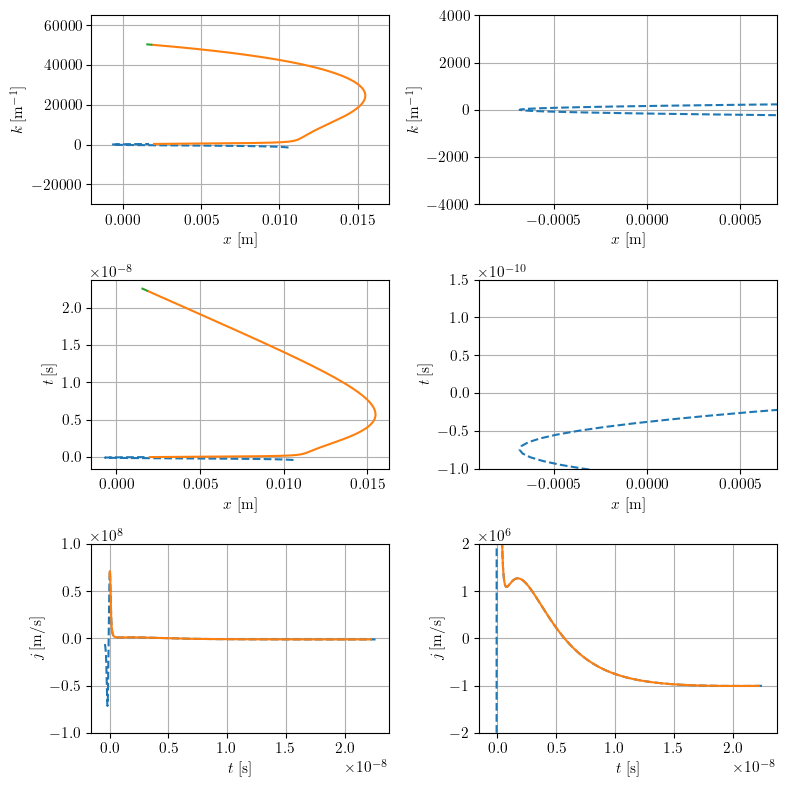

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(8, 8))

ax[0, 0].plot(xs[:i_start], ks[:i_start], '--')
ax[0, 0].plot(xs[i_start:i_end], ks[i_start:i_end])
ax[0, 0].plot(xs[i_end:], ks[i_end:], '--')
ax[0, 0].set_xlim(-2e-3, 17e-3)
ax[0, 0].set_ylim(-30e3, 65e3)
ax[0, 0].set_xlabel(r'$x$ [m]')
ax[0, 0].set_ylabel(r'$k \, \mathrm{[m^{-1}]}$')
ax[0, 0].grid()

ax[0, 1].plot(xs[:i_start, ], ks[:i_start], '--')
ax[0, 1].plot(xs[i_start:i_end], ks[i_start:i_end])
ax[0, 1].plot(xs[i_end:], ks[i_end:], '--')
ax[0, 1].set_xlim(-0.9e-3, 0.7e-3)
ax[0, 1].set_ylim(-4e3, 4e3)
ax[0, 1].set_xlabel(r'$x$ [m]')
ax[0, 1].set_ylabel(r'$k \, \mathrm{[m^{-1}]}$')
ax[0, 1].grid()

ax[1, 0].plot(xs[:i_start], t[:i_start], '--')
ax[1, 0].plot(xs[i_start:i_end], t[i_start:i_end])
ax[1, 0].plot(xs[i_end:], t[i_end:], '--')
# ax[1, 0].invert_yaxis()
ax[1, 0].set_xlabel(r'$x$ [m]')
ax[1, 0].set_ylabel(r'$t \, \mathrm{[s]}$')
ax[1, 0].grid()

ax[1, 1].plot(xs[:i_start], t[:i_start], '--')
ax[1, 1].plot(xs[i_start:i_end], t[i_start:i_end])
ax[1, 1].plot(xs[i_end:], t[i_end:], '--')
ax[1, 1].set_xlim(-0.9e-3, 0.7e-3)
ax[1, 1].set_ylim(-1e-10, 1.5e-10)
# ax[1, 1].invert_yaxis()
ax[1, 1].set_xlabel(r'$x$ [m]')
ax[1, 1].set_ylabel(r'$t \, \mathrm{[s]}$')
ax[1, 1].grid()

ax[2, 0].plot(t, j, '--')
ax[2, 0].plot(t[i_start:i_end], j[i_start:i_end])
ax[2, 0].set_ylim(-1e8,1e8)
ax[2, 0].grid()
ax[2, 0].set_xlabel(r'$t$ [s]')
ax[2, 0].set_ylabel(r'$j \, \mathrm{[m/s]}$')

ax[2, 1].plot(t, j, '--')
ax[2, 1].plot(t[i_start:i_end], j[i_start:i_end])
ax[2, 1].set_ylim(-2e6,2e6)
ax[2, 1].grid()
ax[2, 1].set_xlabel(r'$t$ [s]')
ax[2, 1].set_ylabel(r'$j \, \mathrm{[m/s]}$')

plt.tight_layout()
plt.show()

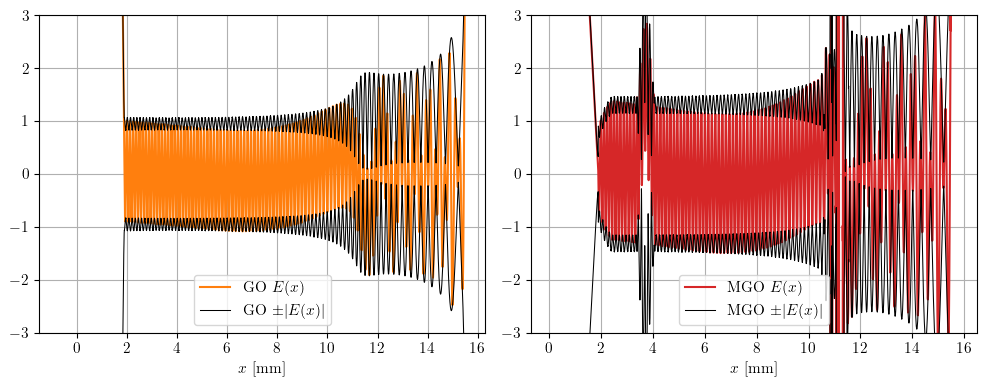

In [27]:
for i, plot_name in enumerate(plot_names):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    field, xs = (mgo_results[i][k] for k in ['field', 'xs'])
    field_go = go_results[i]['field']
    xi = np.linspace(np.min(xs), np.max(xs), 10000)

    ymax = 3
    ax[0].plot(xi * 1e3, np.real(field_go(xi)), '-', color='tab:orange', label='GO $E(x)$')
    ax[0].plot(xi * 1e3, np.abs(field_go(xi)), '-', color='k', label='GO $\pm|E(x)|$', linewidth=0.75)
    ax[0].plot(xi * 1e3, -np.abs(field_go(xi)), '-', color='k', linewidth=0.75)
    ax[0].grid()
    ax[0].set_ylim(-ymax, ymax)
    ax[1].set_xlim(np.min(xi)*1e3, np.max(xi)*1e3+1)
    ax[0].legend()
    ax[0].set_xlabel('$x$ [mm]')

    ax[1].plot(xi * 1e3, np.real(field(xi)), '-', color='tab:red', label='MGO $E(x)$')
    ax[1].plot(xi * 1e3, np.abs(field(xi)), '-', color='k', label='MGO $\pm|E(x)|$', linewidth=0.75)
    ax[1].plot(xi * 1e3, -np.abs(field(xi)), '-', color='k', linewidth=0.75)
    ax[1].grid()
    ax[1].set_ylim(-ymax, ymax)
    ax[1].set_xlim(np.min(xi)*1e3, np.max(xi)*1e3+1)
    ax[1].legend()
    ax[1].set_xlabel('$x$ [mm]')
    
    fig.tight_layout()
    plt.savefig('./plots/XB_mgo_' + plot_name + '.pdf')
    plt.savefig('./plots/XB_mgo_' + plot_name + '.png', dpi=300)
    plt.show()

In [28]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11,
    "axes.titlesize": 11})
rcParams['axes.titlepad'] = 11
cm = 1/2.54 # 1 cm = 1/2.54 inch

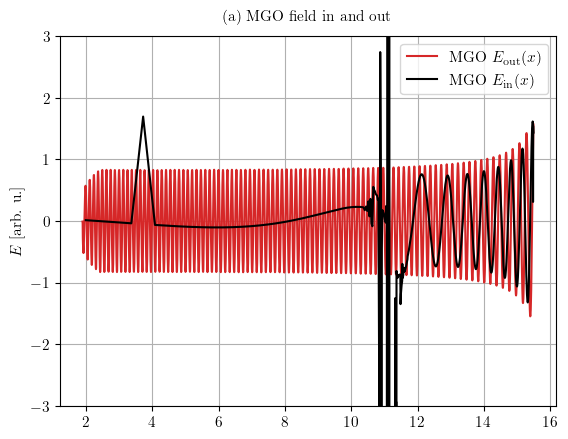

In [30]:
# data0 = np.load('XB0_nt_8509.npz')
data0 = np.load('XB0_nt_4446.npz')
# data0 = np.load('XB0_nt_2223.npz')
t, zs, nt, i_start, i_end, const_T, branch_masks, ray_field, Nt, Upsilon = (data0[k] for k in ['t', 'zs', 'nt', 'i_start', 'i_end', 'const_T', 'branch_masks', 'ray_field', 'Nt', 'Upsilon'])
xs = zs[:, 0]
ks = zs[:, 1]
i_start = int((len(xs) - nt)/2)
i_end = i_start + nt

A0_mgo = 3/(ray_field[branch_masks[1]][0] + ray_field[branch_masks[0]][-1])

# ymax = np.round(np.max(np.abs(ray_field))) + 1.5
ymax = 3
plt.plot(xs[i_start:i_end][branch_masks[1]] * 1e3, np.real(A0_mgo*ray_field[branch_masks[1]]), '-', color='tab:red', label='MGO $E_\mathrm{out}(x)$')
plt.plot(xs[i_start:i_end][branch_masks[0]] * 1e3, np.real(A0_mgo*ray_field[branch_masks[0]]), '-', color='k', label='MGO $E_\mathrm{in}(x)$')
plt.grid()
plt.ylim(-ymax, ymax)
plt.legend()
plt.ylabel(r'$E$ [arb. u.]')
plt.title('(a) MGO field in and out')
plt.show()

In [ ]:
data0 = np.load('XB0_nt_8509.npz')
t, zs, nt, i_start, i_end, const_T, branch_masks, ray_field, Nt, Upsilon = (data0[k] for k in ['t', 'zs', 'nt', 'i_start', 'i_end', 'const_T', 'branch_masks', 'ray_field', 'Nt', 'Upsilon'])
xs = zs[:, 0]
ks = zs[:, 1]
i_start = int((len(xs) - nt)/2)
i_end = i_start + nt

A0_mgo = 3/(ray_field[branch_masks[1]][0] + ray_field[branch_masks[0]][-1])

# ymax = np.round(np.max(np.abs(ray_field))) + 1.5
ymax = 3
plt.plot(xs[i_start:i_end][branch_masks[1]] * 1e3, np.real(A0_mgo*ray_field[branch_masks[1]]), '-', color='tab:red', label='MGO $E_\mathrm{out}(x)$')
plt.plot(xs[i_start:i_end][branch_masks[0]] * 1e3, np.real(A0_mgo*ray_field[branch_masks[0]]), '-', color='k', label='MGO $E_\mathrm{in}(x)$')
plt.grid()
plt.ylim(-ymax, ymax)
plt.legend()
plt.ylabel(r'$E$ [arb. u.]')
plt.title('(a) MGO field in and out')
plt.show()

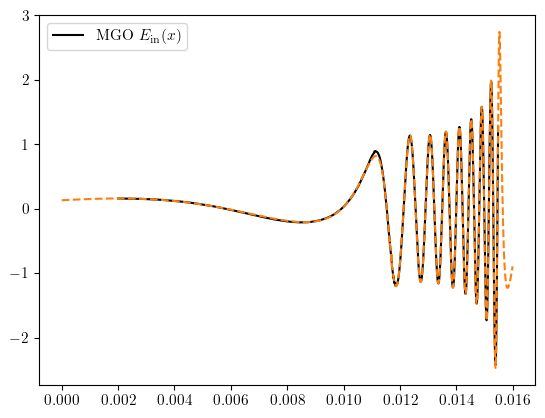

In [15]:
rin = aaa(xs[i_start:i_end][branch_masks[0]], A0_mgo*ray_field[branch_masks[0]], mmax=20)

xi = np.linspace(0, 16e-3, 6000)
plt.plot(xs[i_start:i_end][branch_masks[0]], np.real(A0_mgo*ray_field[branch_masks[0]]), '-', color='k', label='MGO $E_\mathrm{in}(x)$')
plt.plot(xi, np.real(rin(xi)), '--', color='tab:orange')
plt.legend()
plt.show()

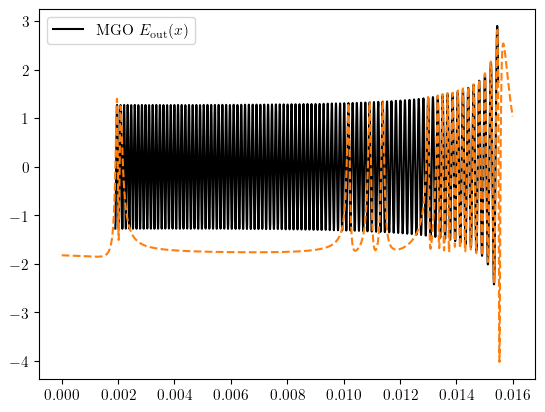

In [16]:
rout = aaa(xs[i_start:i_end][branch_masks[1]], A0_mgo*ray_field[branch_masks[1]], mmax=20)

xi = np.linspace(0, 16e-3, 6000)
plt.plot(xs[i_start:i_end][branch_masks[1]], np.real(A0_mgo*ray_field[branch_masks[1]]), '-', color='k', label='MGO $E_\mathrm{out}(x)$')
plt.plot(xi, np.real(rout(xi)), '--', color='tab:orange')
plt.legend()
plt.show()

In [39]:
import util as ut

PHI1 = np.abs(ray_field[branch_masks[1]])
THETA1 = ut.continuous_angle(ray_field[branch_masks[1]])

rphiout = aaa(xs[i_start:i_end][branch_masks[1]], PHI1, mmax=20)
rthetaout = aaa(xs[i_start:i_end][branch_masks[1]], THETA1, mmax=20)

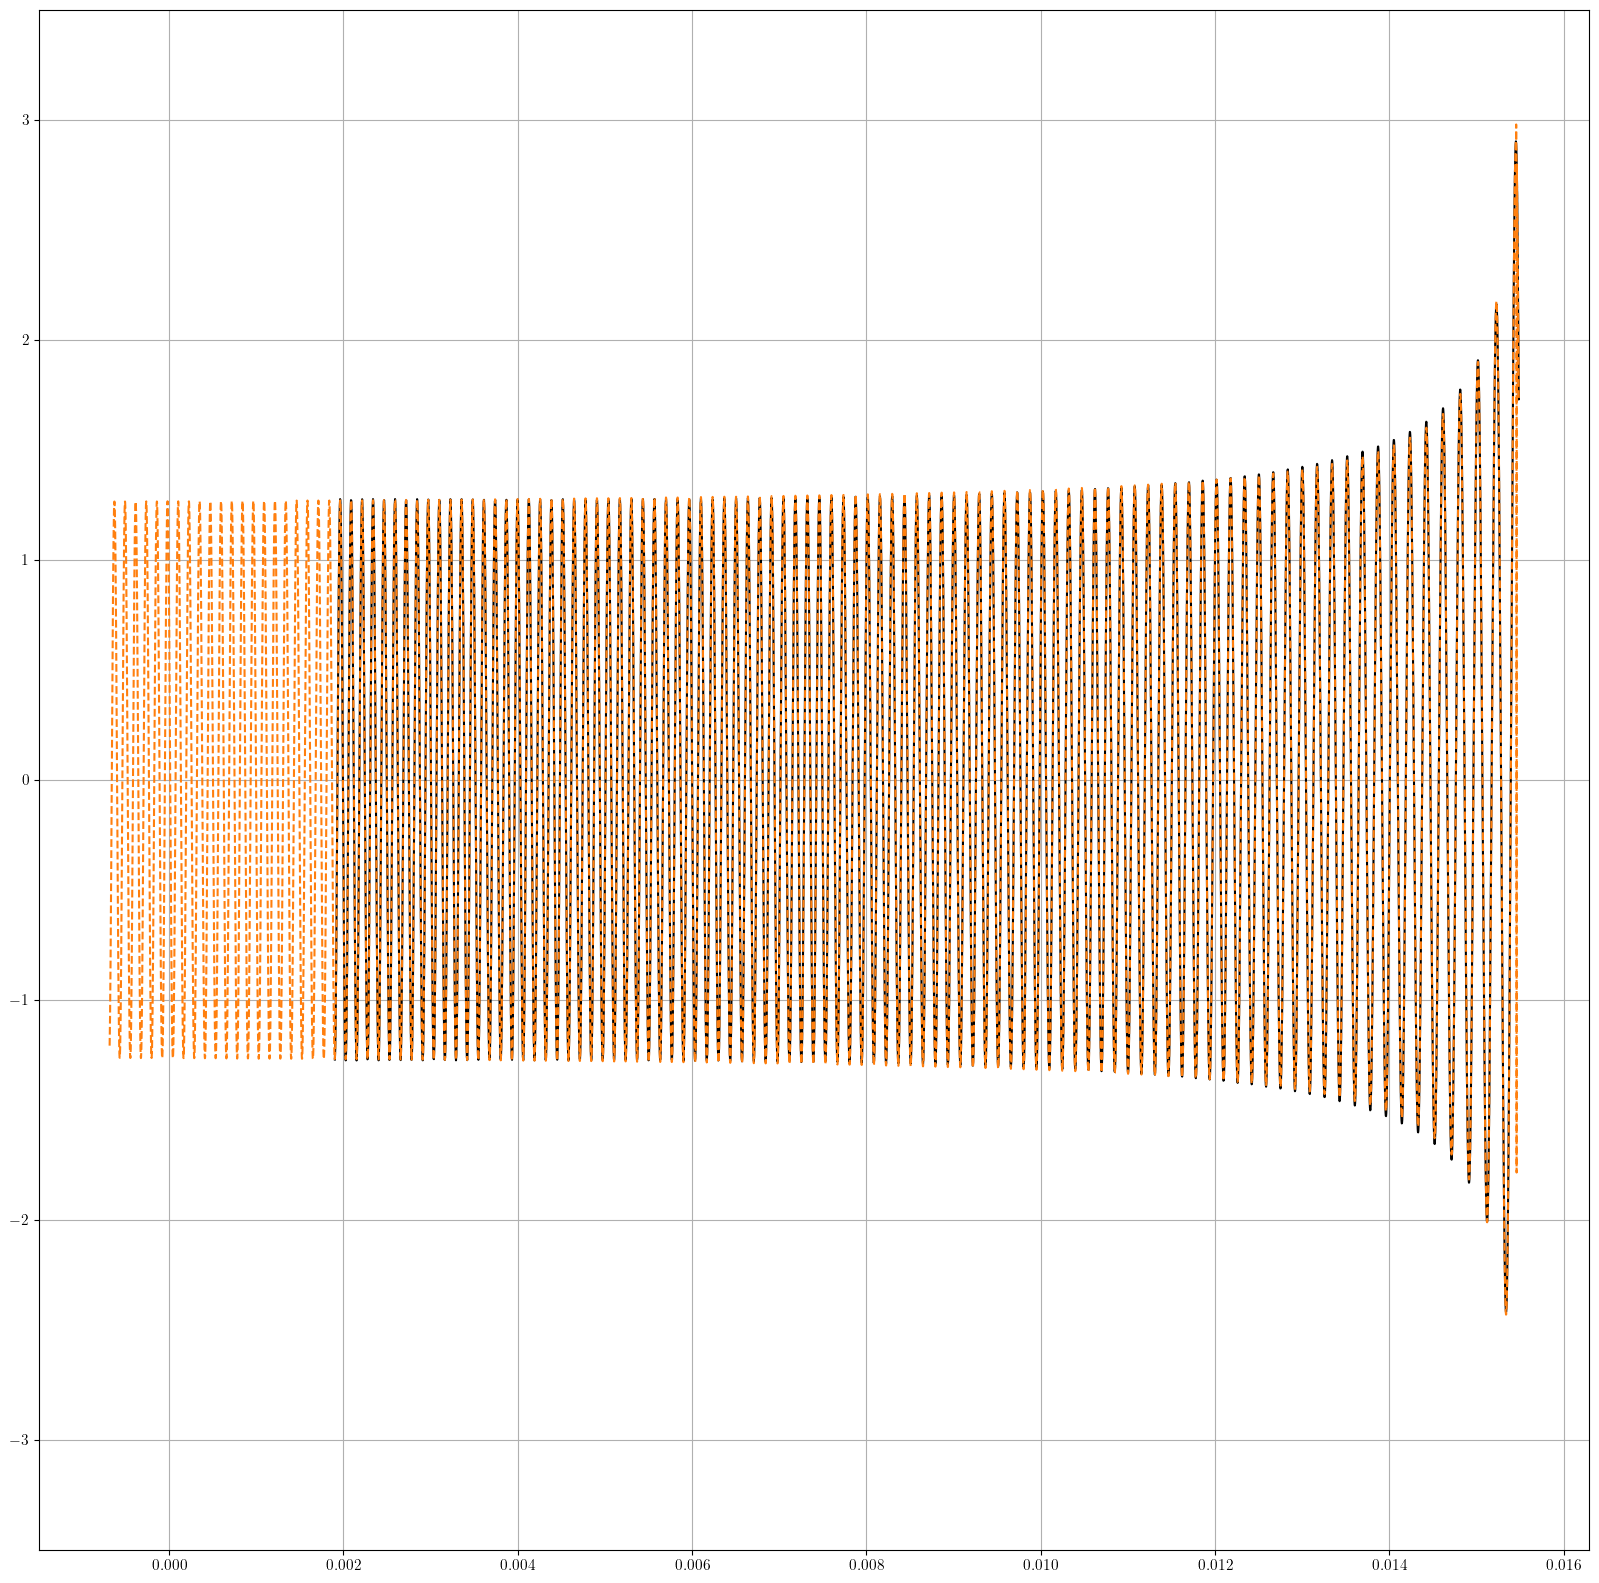

In [40]:
plt.figure(figsize=(20,20))
plt.plot(xs[i_start:i_end][branch_masks[1]], np.real(A0_mgo*ray_field[branch_masks[1]]), '-', color='k', label='MGO $E_\mathrm{out}(x)$')
# plt.plot(xs[i_start:i_end][branch_masks[1]], np.real(A0_mgo*PHI1*np.exp(1j*THETA1)), '--', color='tab:orange')
plt.plot(xi, np.real(A0_mgo*rphiout(xi)*np.exp(1j*rthetaout(xi))), '--', color='tab:orange')
plt.ylim(-3.5, 3.5)
plt.grid()
plt.show()

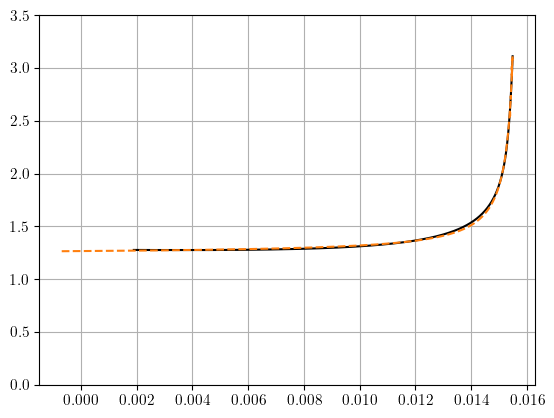

In [41]:
plt.plot(xs[i_start:i_end][branch_masks[1]], np.abs(A0_mgo)*PHI1, 'k-')
plt.plot(xi, np.abs(A0_mgo)*rphiout(xi), '--', color='tab:orange')
plt.ylim(0, 3.5)
plt.grid()
plt.show()

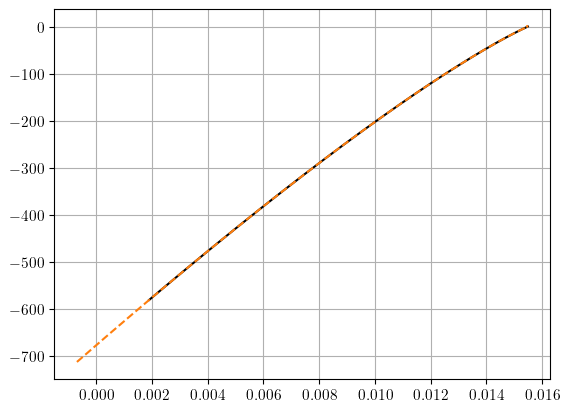

In [42]:
plt.plot(xs[i_start:i_end][branch_masks[1]], THETA1, 'k-')
plt.plot(xi, rthetaout(xi), '--', color='tab:orange')
# plt.ylim(0, 3.5)
plt.grid()
plt.show()

In [43]:
import util as ut

PHI0 = np.abs(ray_field[branch_masks[0]])
THETA0 = ut.continuous_angle(ray_field[branch_masks[0]])

rphiin = aaa(xs[i_start:i_end][branch_masks[0]], PHI0, mmax=20)
rthetain = aaa(xs[i_start:i_end][branch_masks[0]], THETA0, mmax=20)

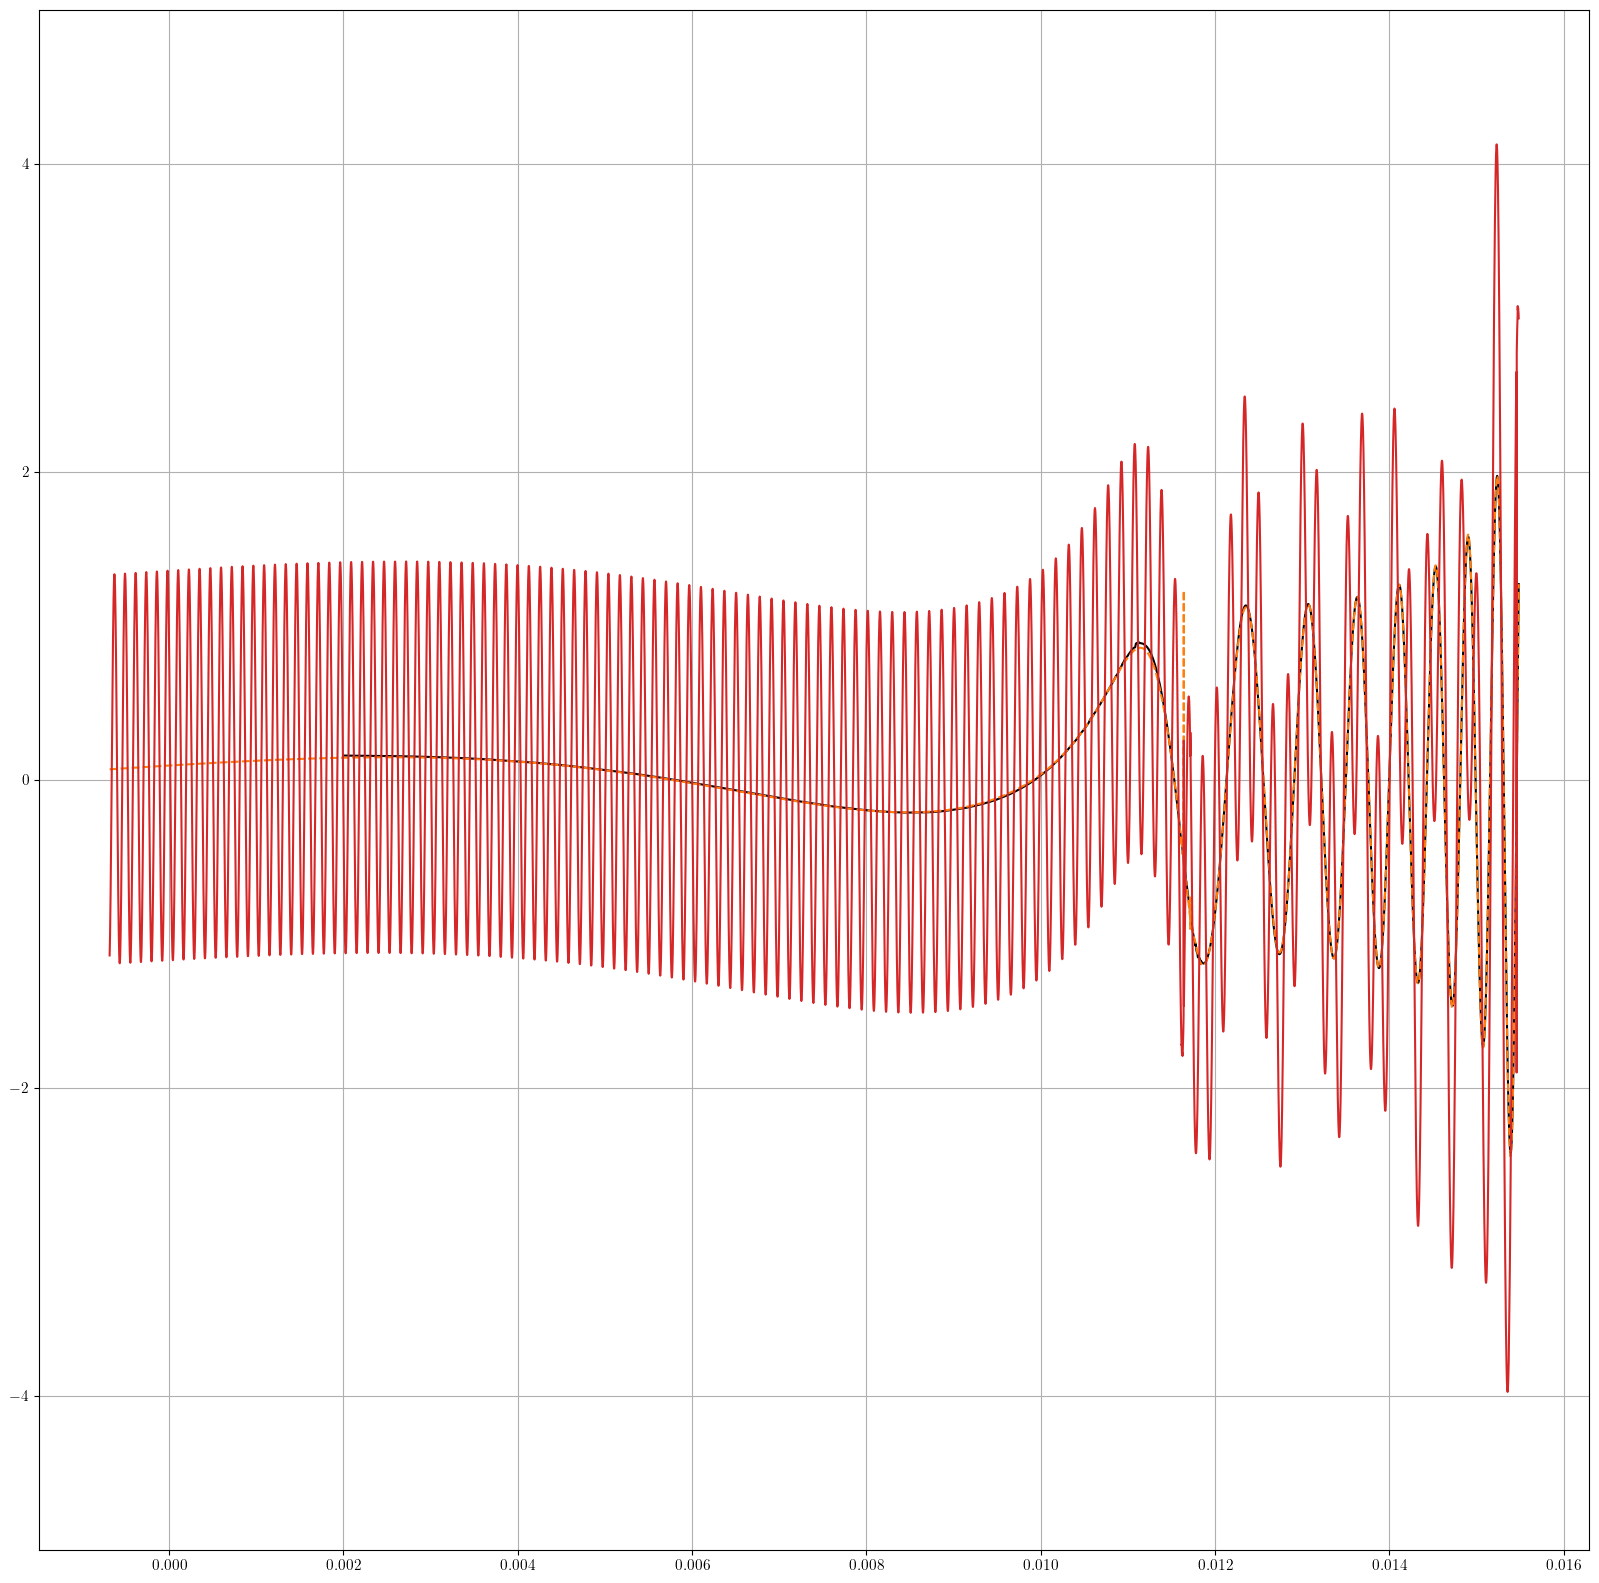

In [45]:
xi = np.linspace(np.min(xs), np.max(xs), 10000)
plt.figure(figsize=(20,20))
plt.plot(xs[i_start:i_end][branch_masks[0]], np.real(A0_mgo*ray_field[branch_masks[0]]), '-', color='k', label='MGO $E_\mathrm{out}(x)$')
# plt.plot(xs[i_start:i_end][branch_masks[1]], np.real(A0_mgo*PHI1*np.exp(1j*THETA1)), '--', color='tab:orange')
plt.plot(xi, np.real(A0_mgo*rphiin(xi)*np.exp(1j*rthetain(xi))), '--', color='tab:orange')
plt.plot(xi, np.real(A0_mgo*rphiin(xi)*np.exp(1j*rthetain(xi)) + A0_mgo*rphiout(xi)*np.exp(1j*rthetaout(xi))), '-', color='tab:red')
plt.ylim(-5, 5)
plt.grid()
plt.show()

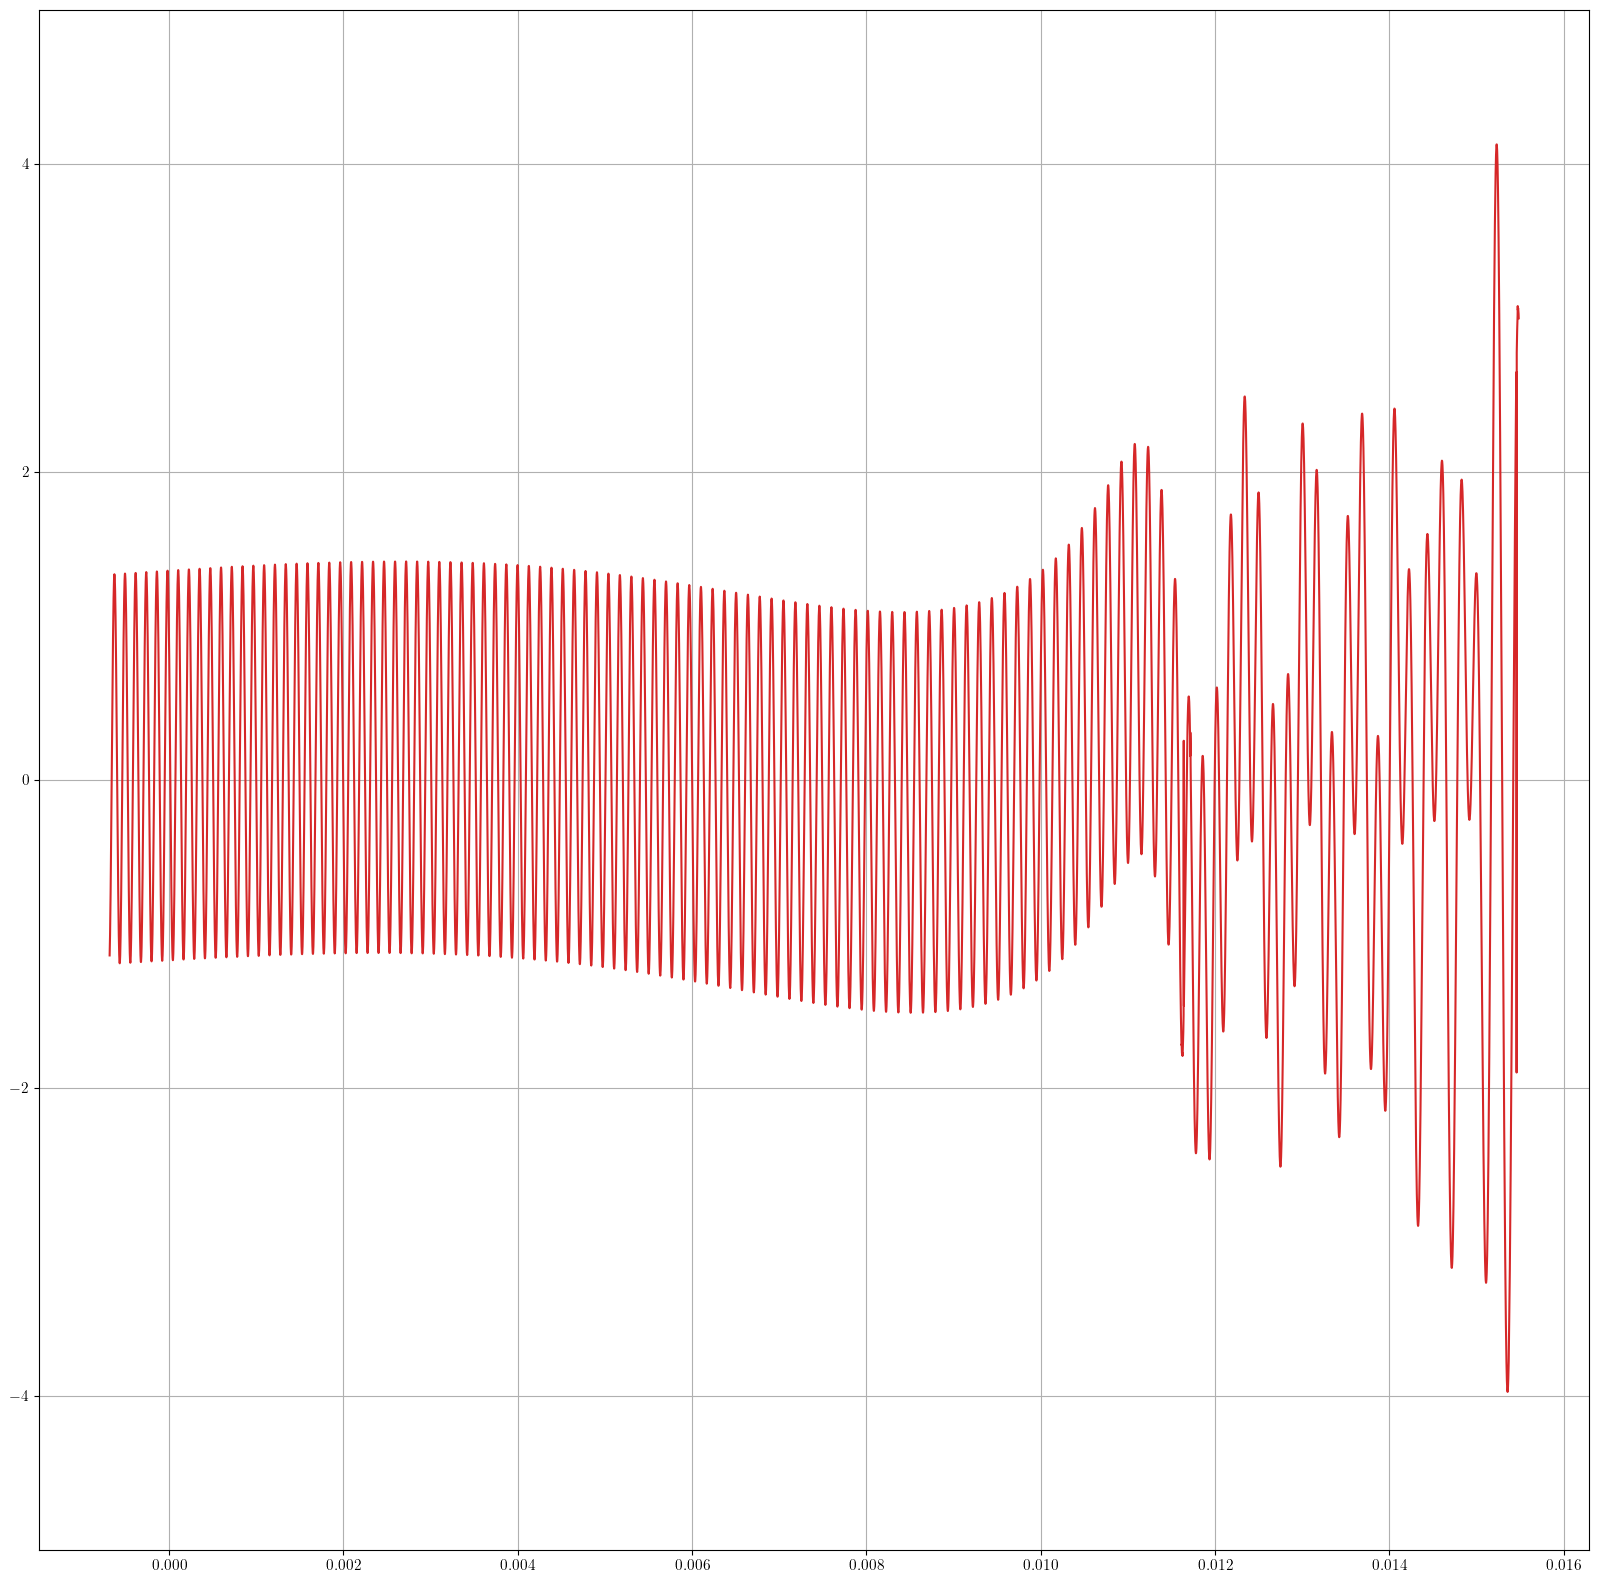

In [46]:
xi = np.linspace(np.min(xs), np.max(xs), 10000)
plt.figure(figsize=(20,20))
# plt.plot(xs[i_start:i_end][branch_masks[0]], np.real(A0_mgo*ray_field[branch_masks[0]]), '-', color='k', label='MGO $E_\mathrm{out}(x)$')
# plt.plot(xs[i_start:i_end][branch_masks[1]], np.real(A0_mgo*PHI1*np.exp(1j*THETA1)), '--', color='tab:orange')
# plt.plot(xi, np.real(A0_mgo*rphiin(xi)*np.exp(1j*rthetain(xi))), '--', color='tab:orange')
plt.plot(xi, np.real(A0_mgo*rphiin(xi)*np.exp(1j*rthetain(xi)) + A0_mgo*rphiout(xi)*np.exp(1j*rthetaout(xi))), '-', color='tab:red')
plt.ylim(-5, 5)
plt.grid()
plt.show()

In [67]:
ray_field_go[branch_masks_go[1]]

array([False, False, False, ...,  True,  True,  True])

In [64]:
A0_go

array([], shape=(0, 5557), dtype=complex128)

/var/folders/r5/t43xdldn22j7t9y2_n0kl3x00000gp/T/ipykernel_20466/97707818.py:41: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


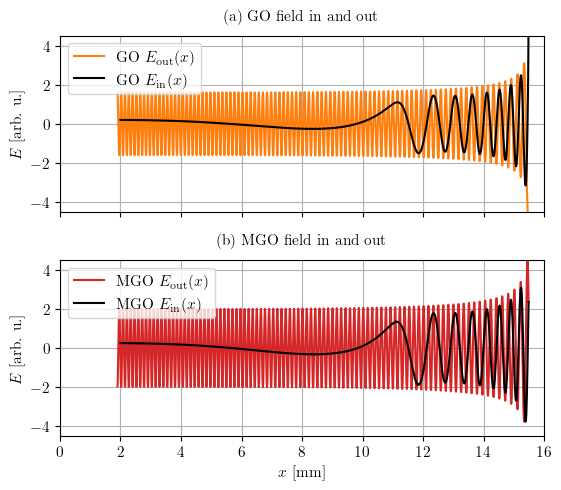

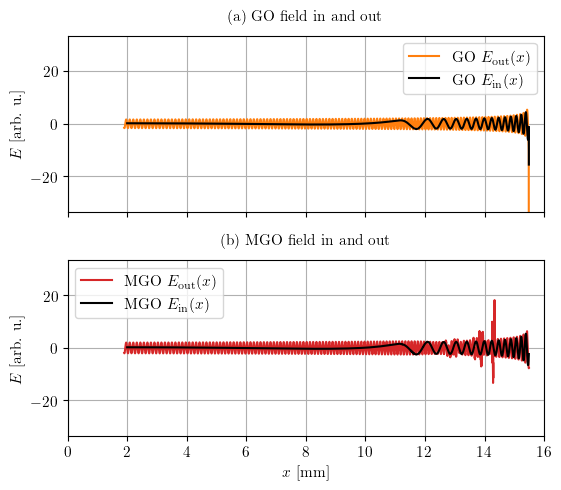

In [44]:
# get_A0_and_interpolation = mgo.get_A0_and_interpolation

for i, plot_name in enumerate(plot_names):
    fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(14.6*cm, 12.8*cm), height_ratios=[2, 2])
    ax0 = plt.subplot(211)
    ax1 = plt.subplot(212)
    # ax2 = plt.subplot(313)

    t, xs, ks, zs, nt, i_start, i_end, x0, k0, S, i_save = ray_tracing_results[i]
    branch_masks, ray_field, field, xs, ks = (mgo_results[i][k] for k in ['branch_masks', 'ray_field', 'field', 'xs', 'ks'])
    branch_masks_go, ray_field_go, field_go = (go_results[i][k] for k in ['branch_masks', 'ray_field', 'field'])

    # A0_mgo, _ = get_A0_and_interpolation(phi0, x0, xs, i_start, i_end, branch_masks, ray_field)
    # A0_go, _ = get_A0_and_interpolation(phi0, x0, xs, i_start, i_end, branch_masks_go, ray_field_go)
    A0_go = 2e-1
    A0_mgo = 2e3

    xi = np.linspace(np.min(xs), np.max(xs), 10000)

    ymax = np.round(np.max(np.abs(field(xi)))) + 1.5
    ax0.sharex(ax1)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax0.plot(xs[i_start:i_end][branch_masks_go[1]] * 1e3, np.real(A0_go*ray_field_go[branch_masks_go[1]]), '-', color='tab:orange', label='GO $E_\mathrm{out}(x)$')
    ax0.plot(xs[i_start:i_end][branch_masks_go[0]] * 1e3, np.real(A0_go*ray_field_go[branch_masks_go[0]]), '-', color='k', label='GO $E_\mathrm{in}(x)$')
    ax0.grid()
    ax0.set_ylim(-ymax, ymax)
    ax0.legend()
    ax0.set_ylabel(r'$E$ [arb. u.]')
    ax0.set_title('(a) GO field in and out')

    ax1.plot(xs[i_start:i_end][branch_masks[1]] * 1e3, np.real(A0_mgo*ray_field[branch_masks[1]]), '-', color='tab:red', label='MGO $E_\mathrm{out}(x)$')
    ax1.plot(xs[i_start:i_end][branch_masks[0]] * 1e3, np.real(A0_mgo*ray_field[branch_masks[0]]), '-', color='k', label='MGO $E_\mathrm{in}(x)$')
    ax1.grid()
    ax1.set_ylim(-ymax, ymax)
    ax1.set_xlim(0, 16)
    ax1.legend()
    ax1.set_ylabel(r'$E$ [arb. u.]')
    ax1.set_title('(b) MGO field in and out')
    ax1.set_xlabel('$x$ [mm]')

    fig.tight_layout()
    plt.savefig('./plots/XB_mgo_in_out_' + plot_name + '_aaa.pdf')
    plt.savefig('./plots/XB_mgo_in_out_' + plot_name + '_aaa.png', dpi=300)
    plt.show()

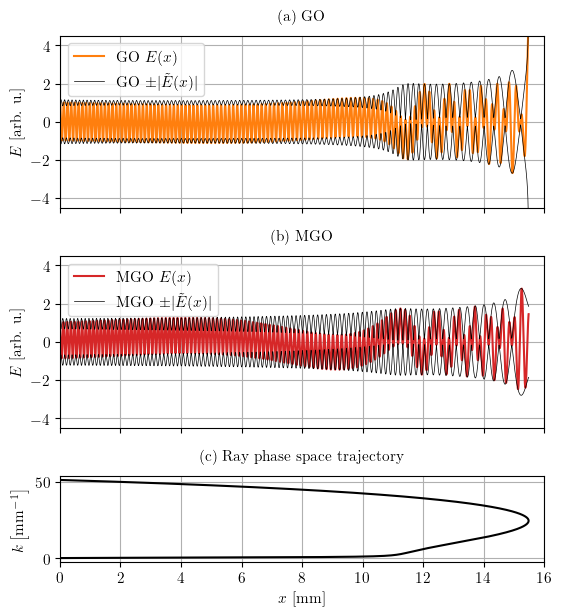

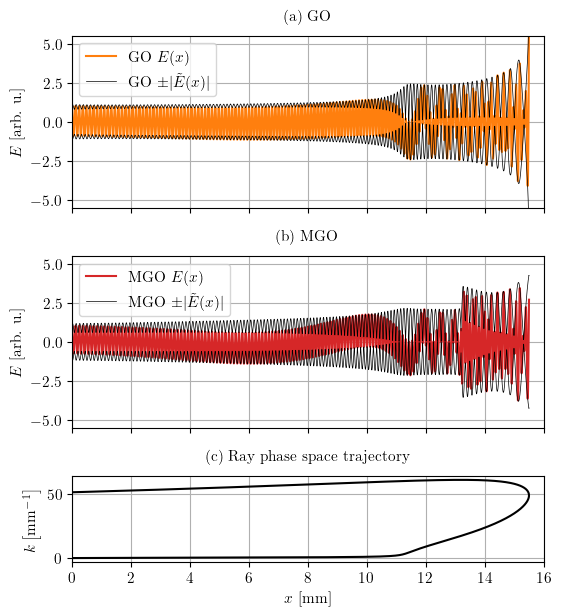

In [21]:
for i, plot_name in enumerate(plot_names):
    fig, ax = plt.subplots(3, 1, constrained_layout=True, figsize=(14.6*cm, 16*cm), height_ratios=[2, 2, 1])
    ax0 = plt.subplot(311)
    ax1 = plt.subplot(312)
    ax2 = plt.subplot(313)

    field, xs, ks = (mgo_results[i][k] for k in ['field', 'xs', 'ks'])
    field_go = go_results[i]['field']
    xi = np.linspace(np.min(xs), np.max(xs), 10000)

    ymax = np.round(np.max(np.abs(field(xi)))) + 1.5
    ax0.sharex(ax2)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax0.plot(xi * 1e3, np.real(field_go(xi)), '-', color='tab:orange', label='GO $E(x)$')
    ax0.plot(xi * 1e3, np.abs(field_go(xi)), '-', color='k', label=r'GO $\pm|\tilde{E}(x)|$', linewidth=0.5)
    ax0.plot(xi * 1e3, -np.abs(field_go(xi)), '-', color='k', linewidth=0.5)
    ax0.grid()
    ax0.set_ylim(-ymax, ymax)
    # ax.set_xlim(0, 16)
    ax0.legend()
    ax0.set_ylabel(r'$E$ [arb. u.]')
    ax0.set_title('(a) GO')
    # ax[1].set_xlabel('$x$ [mm]')

    ax1.sharex(ax2)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.plot(xi * 1e3, np.real(field(xi)), '-', color='tab:red', label='MGO $E(x)$')
    ax1.plot(xi * 1e3, np.abs(field(xi)), '-', color='k', label=r'MGO $\pm|\tilde{E}(x)|$', linewidth=0.5)
    ax1.plot(xi * 1e3, -np.abs(field(xi)), '-', color='k', linewidth=0.5)
    ax1.grid()
    ax1.set_ylim(-ymax, ymax)
    # ax.set_xlim(0, 16)
    ax1.legend()
    ax1.set_ylabel(r'$E$ [arb. u.]')
    ax1.set_title('(b) MGO')
    # ax.set_xlabel('$x$ [mm]')

    ax2.plot(xs.squeeze()*1e3, ks.squeeze()*1e-3, 'k-')
    ax2.set_xlim(0, 16)
    ax2.grid()
    ax2.set_xlabel(r'$x$ [mm]')
    ax2.set_ylabel(r'$k \, \mathrm{\left[ mm^{-1} \right]}$')
    ax2.set_title('(c) Ray phase space trajectory')

    fig.tight_layout()
    plt.savefig('./plots/XB_mgo_' + plot_name + '_' + deg_str + '.pdf')
    plt.savefig('./plots/XB_mgo_' + plot_name + '_' + deg_str + '.png', dpi=300)
    plt.show()

In [22]:
C = lambda l, sigma_p, sigma_m, s_p, s_m: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: np.exp(1j*sigma_m)/np.emath.sqrt(s_m), lambda l: np.exp(1j*sigma_p)/np.emath.sqrt(s_p)])
C_R = lambda l, sigma_p, sigma_m, s_p, s_m: np.real(C(l, sigma_p, sigma_m, s_p, s_m))
C_I = lambda l, sigma_p, sigma_m, s_p, s_m: np.imag(C(l, sigma_p, sigma_m, s_p, s_m))

l_j, _ = get_nodes_and_weights(n=10)
l_j = l_j.astype(np.complex_)

def get_eps(s_m, s_p):
    epsmax = np.max([1/np.sqrt(s_m[0]), 1/np.sqrt(s_p[0])])
    eps_R = np.linspace(-5*epsmax,5*epsmax, 1000)
    eps_I = np.linspace(-5*epsmax,5*epsmax, 1000)
    Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
    Eps = Eps_R + 1j*Eps_I
    return Eps_R, Eps_I, Eps 

from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11})
rcParams['axes.titlepad'] = 14

cm = 1/2.54 # 1 cm = 1/2.54 inch

/Users/rune.hoejlund/opt/anaconda3/envs/ray-tracer/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


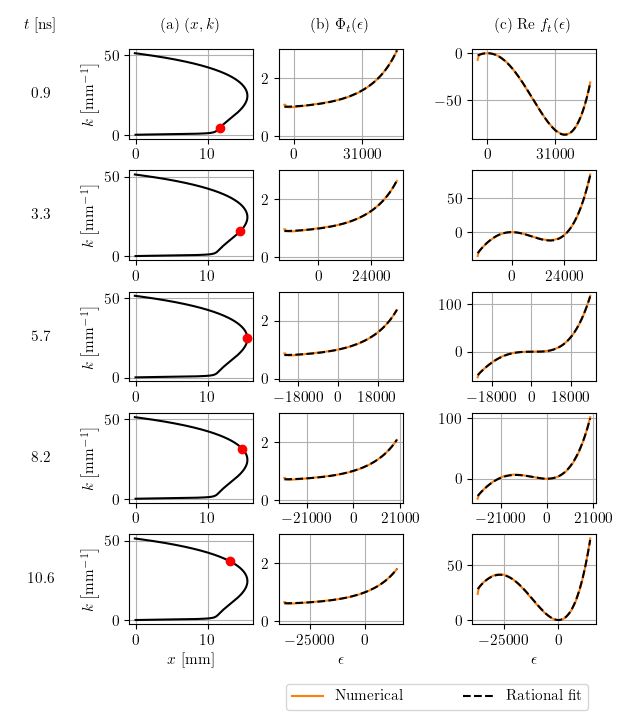

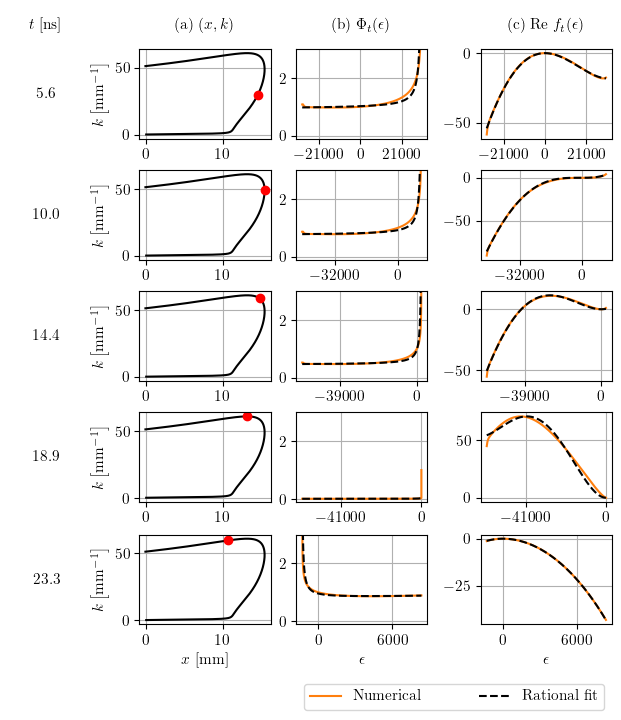

In [23]:
for j, plot_name in enumerate(plot_names):
    sorted_results = sorted_results=sorted(detailed_results[j], key=lambda d: d['t1'])
    field, xs, ks = (mgo_results[j][k] for k in ['field', 'xs', 'ks'])

    vmin, vmax = -80, 80
    cmap = mpl.cm.RdBu_r
    levels = np.linspace(vmin, vmax, 20)
    norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')

    nrows = 2+len(sorted_results)*3
    n_cols = 11
    fig = plt.figure(constrained_layout=True, figsize=(15.5*cm, 18*cm))
    gs = GridSpec(nrows, n_cols, figure=fig)

    def is_end(i):
        return i == len(sorted_results) - 1

    def row_range(i):
            return slice(1+3*i,1+3*(i+1))

    col_ranges = [slice(0, 2), slice(2, 5), slice(5, 8), slice(8, 11)]
    col_titles = [r'$t$ [ns]', r'(a) $(x, k)$', r'(b) $\Phi_t(\epsilon)$', r'(c) Re $f_t(\epsilon)$']

    for col_range, title in zip(col_ranges, col_titles):
        ax = fig.add_subplot(gs[0, col_range])
        ax.text(0.5, 0.5, title, va="center", ha="center")
        plt.axis('off')

    get_eps_xticks = lambda eps_rho: [-5]*int(np.min(eps_rho) <= -5) + [-2]*int(np.min(eps_rho) > -5 and np.max(eps_rho) < 5) + [0] + [2]*int(np.min(eps_rho) > -5 and np.max(eps_rho) < 5) + [5]*int(np.max(eps_rho) >= 5)

    for i, result in enumerate(sorted_results):
        t1, it, mask_t1, eps_rho, Theta_t1, f_t1, f_fit, ddf_fit, Phi_t1, g_fit, sigma_p, sigma_m, s_p, s_m, l_p, l_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'Theta_t1', 'f_t1', 'f_fit', 'ddf_fit', 'Phi_t1', 'g_fit', 'sigma_p', 'sigma_m', 's_p', 's_m', 'l_p', 'l_m'])
        eps_rho = eps_rho.squeeze()

        ax = fig.add_subplot(gs[row_range(i), col_ranges[0]])
        ax.text(0.5, 0.5, r'$' + str(round(t1*1e9, 1)) + '$', va="center", ha="center")
        plt.axis('off')
        
        ax = fig.add_subplot(gs[row_range(i), col_ranges[1]])
        ax.plot(xs*1e3, ks*1e-3, 'k-')
        ax.plot(xs[it]*1e3, ks[it]*1e-3, 'ro')
        ax.grid()
        ax.set_ylabel(r'$k \, \mathrm{\left[ mm^{-1} \right]}$')
        if is_end(i):
            ax.set_xlabel(r'$x$ [mm]')

        ax = fig.add_subplot(gs[row_range(i), col_ranges[2]])
        ax.plot(eps_rho, Phi_t1, '-', color='tab:orange')
        ax.plot(eps_rho, g_fit(eps_rho), '--', color='k')
        ax.set_ylim(-0.1, 3)
        ax.grid()
        if is_end(i):
            ax.set_xlabel(r'$\epsilon$')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.round(np.max(np.abs(eps_rho))*2/3, -3))))
        
        ax = fig.add_subplot(gs[row_range(i), col_ranges[3]])
        ax.plot(eps_rho, f_t1, '-', color='tab:orange')
        ax.plot(eps_rho, f_fit(eps_rho), '--', color='k')
        ax.grid()
        if is_end(i):
            ax.set_xlabel(r'$\epsilon$')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.round(np.max(np.abs(eps_rho))*2/3, -3))))

    ax = fig.add_subplot(gs[-1:, slice(col_ranges[2].start, col_ranges[3].stop)])
    ax.plot(1, '-', color='tab:orange', label='Numerical')
    ax.plot(1, '--', color='k', label='Rational fit')
    plt.axis('off')
    ax.legend(mode='expand', ncols=2)

    fig.savefig('./plots/XB_mgo_steps_2_' + plot_name + '_' + deg_str + '.pdf')
    fig.savefig('./plots/XB_mgo_steps_2_' + plot_name + '_' + deg_str + '.png', dpi=300)
    plt.show()